In [28]:
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
from IPython.utils import io
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Activation

In [29]:
features = pd.read_csv('gastrointestinal_colonoscopy_lesions_dataset.csv')
features = features.T
class_label = pd.Series(features.index)
features.index = range(features.shape[0])
classes = np.zeros((features.shape[0], 3))
for i in range(classes.shape[0]):
    if 'adenoma' in class_label[i]:
        classes[i,0] = 1.0
        class_label[i] = 0
    elif 'serrated' in class_label[i]:
        classes[i,2] = 1.0
        class_label[i] = 2
    else:
        classes[i,1] = 1.0
        class_label[i] = 1
classes = {'adenoma': classes[:,0], 'hyperplasic': classes[:,1], 'serrated': classes[:,2]}
classes = pd.DataFrame(classes)
class_label = class_label.astype('int')

In [30]:
for col in features.columns:
    if features[col].abs().max()==0:
        continue
    features[col] = (features[col] - features[col].mean())/features[col].abs().max()
features

,0,1,2,3,4,5,6,7,8,9,...,690,691,692,693,694,695,696,697,698,699
0,0.250000,-0.25,0.048325,-0.005553,-0.056058,-0.084224,-0.037834,-0.031987,-0.101462,-0.050684,...,0.397177,0.392793,0.388256,0.383761,0.384351,0.383117,0.379185,0.365162,0.365579,0.375950
1,0.250000,0.25,-0.001203,0.367137,-0.084265,-0.100569,0.018451,0.046227,-0.101911,-0.038210,...,0.397177,0.392793,0.388256,0.383761,0.384351,0.383117,0.379185,0.365162,0.365579,0.375950
2,0.250000,0.25,-0.233810,0.046065,0.024136,0.032700,-0.031101,-0.036372,-0.169688,-0.154002,...,0.060715,0.057743,0.055493,0.056890,0.052044,0.053244,0.052057,0.045743,0.046962,0.047065
3,0.250000,-0.25,-0.182565,0.057049,-0.031463,-0.025114,-0.050518,-0.035422,-0.067798,-0.052955,...,0.060715,0.057743,0.055493,0.056890,0.052044,0.053244,0.052057,0.045743,0.046962,0.047065
4,0.250000,0.25,-0.107936,-0.094438,0.092679,0.038768,0.186656,0.125008,0.095410,0.078630,...,-0.054256,-0.053808,-0.052869,-0.052718,-0.051934,-0.051097,-0.050394,-0.050345,-0.049870,-0.049726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,-0.083333,0.25,0.040649,-0.066683,-0.185786,-0.250955,-0.163660,-0.173238,-0.232896,-0.223542,...,-0.054095,-0.053643,-0.052701,-0.052581,-0.051796,-0.050957,-0.050288,-0.050236,-0.049758,-0.049611
148,-0.083333,0.25,-0.153445,0.092191,-0.010435,-0.057762,-0.097339,-0.111005,-0.120050,0.000883,...,-0.043740,-0.044039,-0.043146,-0.043641,-0.042803,-0.042638,-0.042785,-0.042676,-0.042227,-0.042307
149,-0.083333,-0.25,0.144594,0.231284,-0.043448,-0.041229,-0.173962,-0.202734,-0.153664,-0.000519,...,-0.043740,-0.044039,-0.043146,-0.043641,-0.042803,-0.042638,-0.042785,-0.042676,-0.042227,-0.042307
150,-0.083333,-0.25,-0.169496,-0.098815,-0.207792,-0.250433,-0.221289,-0.226000,0.073333,0.138157,...,-0.053643,-0.053247,-0.052332,-0.052204,-0.051450,-0.050608,-0.049938,-0.049907,-0.049461,-0.049344


In [31]:
model = Sequential([
    
    InputLayer(input_shape=(features.shape[1])),
    
    Dense(7, activation='sigmoid'),
    
    Dense(5, activation='sigmoid'),
    
    Dense(3, activation='sigmoid')
])

model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
             )
model.summary()
model.save_weights('model_weights/initial_weights_colonoscopy')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 7)                 4907      
                                                                 
 dense_4 (Dense)             (None, 5)                 40        
                                                                 
 dense_5 (Dense)             (None, 3)                 18        
                                                                 
Total params: 4,965
Trainable params: 4,965
Non-trainable params: 0
_________________________________________________________________


In [32]:
acc = 0
j = 0
for train_index, test_index in LeaveOneOut().split(features):
    x_train, x_test = features.iloc[train_index,:], features.iloc[test_index,:]
    y_train, y_test = classes.iloc[train_index,:], classes.iloc[test_index,:]
    model.load_weights('model_weights/initial_weights_colonoscopy')
    with io.capture_output() as captured:
        model.fit(x_train, y_train, epochs=500)
    acc += model.evaluate(x_test, y_test)[1]
    j+=1

1/1 [==============================] - 0s 18ms/step - loss: 0.7307 - accuracy: 0.0000e+00


In [33]:
print('Accuracy: ', acc/j)

Accuracy:  0.8421052631578947


In [34]:
model.fit(features, classes, epochs=500)

Epoch 1/500
5/5 [==============================] - 0s 3ms/step - loss: 0.1121 - accuracy: 0.9934
Epoch 2/500
5/5 [==============================] - 0s 3ms/step - loss: 0.1114 - accuracy: 0.9934
Epoch 3/500
5/5 [==============================] - 0s 3ms/step - loss: 0.1105 - accuracy: 0.9934
Epoch 4/500
5/5 [==============================] - 0s 4ms/step - loss: 0.1097 - accuracy: 0.9934
Epoch 5/500
5/5 [==============================] - 0s 3ms/step - loss: 0.1090 - accuracy: 0.9934
Epoch 6/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1082 - accuracy: 0.9934
Epoch 7/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1075 - accuracy: 0.9934
Epoch 8/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1067 - accuracy: 0.9934
Epoch 9/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1061 - accuracy: 0.9934
Epoch 10/500
5/5 [==============================] - 0s 2ms/step - loss: 0.1054 - accuracy: 0.9934
Epoch 11/500
5/5 [===========

In [35]:
grad_sum = 0
for col_name in tqdm(features.columns):
    pointFrame = features.loc[:, features.columns != col_name]
    for i in features[col_name]:
        pointFrame[col_name] = i*np.ones(len(features.index))
        points = tf.Variable(pointFrame, dtype='float')
        with tf.GradientTape() as tape:
            pred = model(points, training=False)
        grads = tape.gradient(pred, points)
        grad_sum += np.abs(grads.numpy())
saliency_order = np.argsort(-np.sum(np.abs(grad_sum), 0))

100%|██████████| 700/700 [06:34<00:00,  1.78it/s]


In [36]:
print('The features arranged in order of saliency are: \n')
features[saliency_order]

The features arranged in order of saliency are: 



,0,547,464,455,146,545,549,546,571,521,...,208,172,452,176,244,454,321,220,390,409
0,0.250000,0.019453,0.156682,-0.008144,0.014037,0.020956,0.013944,0.017661,-0.000891,0.019545,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.250000,0.019453,-0.071990,-0.008144,0.009191,0.020956,0.013944,0.017661,-0.000891,0.019545,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.250000,0.012418,-0.131291,0.229704,0.008758,0.007180,0.016346,-0.007271,0.008760,0.000482,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.250000,0.012418,-0.140440,-0.008144,0.066090,0.007180,0.016346,-0.007271,0.008760,0.000482,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.250000,0.018683,-0.029781,-0.008144,-0.104275,0.012956,0.017094,0.021297,0.011717,-0.004381,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,-0.083333,0.006751,0.063551,-0.008144,-0.029268,0.018410,-0.003144,0.006035,-0.016223,0.089982,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,-0.083333,0.009858,-0.040653,-0.008144,-0.007182,0.009247,0.007949,0.009186,0.012807,0.019351,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149,-0.083333,0.009858,-0.026035,-0.008144,0.030283,0.009247,0.007949,0.009186,0.012807,0.019351,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150,-0.083333,-0.044736,-0.140440,-0.008144,-0.007820,-0.043478,-0.039516,-0.050214,0.009538,0.004470,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[]

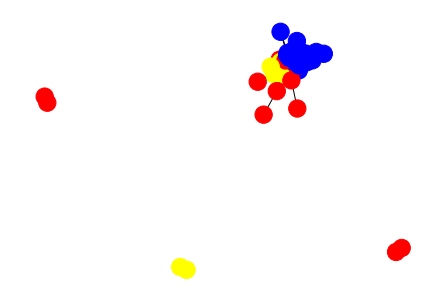

In [37]:
num_features = 100
salient_features = features.iloc[:,saliency_order[0:num_features]]
A = np.zeros((features.shape[0], features.shape[0]))
for i in features.index:
    for j in range(i):
        A[i,j] = np.linalg.norm(salient_features.iloc[i,:] - salient_features.iloc[j,:])
A = A + np.transpose(A)
p = 1.3
A = (A < p)
A = A - np.eye(A.shape[0])
rows, cols = np.where(A==1)
edges = zip(rows.tolist(), cols.tolist())
G = nx.Graph()
G.add_edges_from(edges, node_size=1)
color_map = np.array([])
for node in G:
    if (class_label[node]==0):
        color_map = np.append(color_map, 'red')
    elif (class_label[node]==1):
        color_map = np.append(color_map, 'blue')
    else:
        color_map = np.append(color_map, 'yellow')
nx.draw(G, node_color=color_map)
plt.plot()

In [38]:
nx.is_connected(G) # tells whether or not the graph is connected
# nx.clustering(G) # gives the clustering value of each vertex

False

In [39]:
nx.number_connected_components(G) # number of different connected components

4

In [40]:
nx.density(G) # this tells how close the graph is to being fully connected


0.4695302013422819

In [41]:
nx.average_clustering(G) # clustering value for the whole graph

0.7561923178052088

In [42]:
nx.transitivity(G) # 3* number of triangles in G/ number of connected triads in G

0.8007330739533417

[]

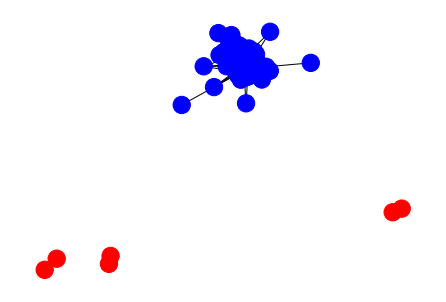

In [43]:
giant_component = G.subgraph(max(nx.connected_components(G), key=len))
color_map_GC = np.array([])
for node in G:
    if node in giant_component:
        color_map_GC = np.append(color_map_GC, 'blue')
    else:
        color_map_GC = np.append(color_map_GC, 'red')
nx.draw(G, node_color=color_map_GC)
plt.plot()

In [44]:
print(f'Eccentricity of giant component: {nx.eccentricity(giant_component)}') # largest possible shortest path distance between a vertex and all other vertices
print(f'Diameter of giant component: {nx.diameter(giant_component)}') # maximum shortest distance between a pair of vertices in G, it is the largest possible eccentricity value of a vertex
print(f'Radius of giant component: {nx.radius(giant_component)}') #  minimum eccentricity value of a vertex

print(f'Degree centrality: \n{nx.degree_centrality(G)}') # number of edges incident upon a vertex
print(f'Maximum degree centrality: {max(nx.degree_centrality(G))}')
print(f'Degree histogram: {nx.degree_histogram(G)}')

# below gives us the different centrality measures for the vertices of the graphs
print(f'Eigenvector centrality: \n{nx.eigenvector_centrality(G)}')
print(f'Maximum eigenvector centrality: {max(nx.eigenvector_centrality(G))}')
print(f'Closeness centrality: \n{nx.closeness_centrality(G)}')
print(f'Maximum closeness centrality: {max(nx.closeness_centrality(G))}')
print(f'Betweeness centrality: \n{nx.betweenness_centrality(G)}')
print(f'Maximum betweeness centrality: {max(nx.betweenness_centrality(G))}')

Eccentricity of giant component: {0: 3, 1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 3, 17: 3, 18: 3, 20: 3, 21: 3, 22: 3, 23: 3, 24: 3, 25: 3, 26: 3, 27: 3, 28: 3, 29: 3, 30: 3, 31: 3, 32: 3, 33: 3, 34: 3, 35: 3, 36: 3, 37: 3, 38: 3, 39: 3, 41: 3, 42: 3, 43: 3, 46: 3, 47: 3, 50: 3, 51: 3, 52: 3, 53: 3, 54: 3, 55: 3, 56: 3, 57: 3, 58: 3, 59: 3, 60: 3, 61: 3, 62: 3, 63: 3, 64: 3, 65: 3, 66: 3, 67: 3, 72: 3, 73: 4, 75: 3, 76: 3, 77: 3, 78: 3, 81: 3, 89: 3, 92: 3, 96: 3, 100: 3, 102: 3, 116: 3, 122: 3, 123: 3, 124: 3, 125: 3, 126: 3, 127: 3, 128: 3, 129: 3, 132: 3, 133: 3, 136: 3, 137: 3, 138: 3, 139: 3, 140: 3, 141: 3, 142: 3, 143: 3, 144: 3, 145: 3, 146: 3, 147: 3, 148: 3, 149: 3, 150: 3, 151: 3, 99: 4, 90: 4, 97: 3, 113: 3, 40: 4, 74: 3, 68: 4, 69: 3, 88: 4, 108: 4, 130: 4, 131: 4, 82: 3, 91: 3, 95: 3, 115: 4, 117: 4, 118: 4, 121: 4, 101: 4, 19: 4, 87: 4, 80: 3, 85: 4, 49: 4, 84: 4, 83: 4, 79: 5, 48: 5, 114: 4, 98: 4, 105: 4, 103: 

In [45]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(salient_features)
print('Number of Iterations: ', kmeans.n_iter_)
predicted_label = kmeans.labels_

Number of Iterations:  4


In [46]:
print('Cluster Centers: ', kmeans.cluster_centers_)

Cluster Centers:  [[-3.78787879e-01 -1.33622548e-02  6.22432333e-02 -8.14373591e-03
   1.02845798e-02 -1.36280299e-02 -1.04173427e-02 -1.20615760e-02
  -4.09597530e-03 -9.33434578e-03 -6.11565911e-03 -3.68607991e-02
  -2.18197659e-02 -1.72728874e-02 -3.46690162e-04 -9.59856778e-03
  -3.59396728e-03  2.75583230e-02  5.00152880e-04 -3.57427314e-03
   4.43402190e-03 -1.17129404e-02 -5.96272848e-05  8.31202769e-02
  -1.70953084e-02 -4.21875938e-02  1.29722300e-02 -2.19361480e-02
  -1.11221258e-02 -2.74204462e-02 -6.31868799e-02  7.45674683e-02
  -4.22829818e-02 -3.57856351e-03  8.98518730e-02 -4.32625390e-03
   7.21976561e-02 -1.40643205e-02  6.48230522e-02 -7.59624248e-02
  -1.22001867e-02 -1.41937736e-02  2.00973243e-02 -3.16104778e-02
   4.45750499e-02  2.97635077e-02 -1.14808529e-01  4.44092364e-02
   4.46751978e-02 -4.49935358e-03 -5.36150809e-03 -2.55158886e-02
  -4.51761107e-02 -1.43624085e-01 -5.37239374e-02  1.87573022e-02
  -5.72819611e-02  7.11306696e-02  8.96257178e-03 -1.72272

In [47]:
print('Inertia: ', kmeans.inertia_) # SSE

Inertia:  122.31186650528306


In [48]:
compared_classes = np.array([])
for i in classes.iterrows():
    if i[1]['adenoma']==1:
        compared_classes = np.append(compared_classes, 2)
    elif i[1]['hyperplasic']==1:
        compared_classes = np.append(compared_classes, 1)
    else:
        compared_classes = np.append(compared_classes, 0)
print('KMeans accuracy for 3 classes: ', np.count_nonzero(compared_classes==predicted_label)/len(predicted_label))

KMeans accuracy for 3 classes:  0.4934210526315789


In [49]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(salient_features)
print('Number of Iterations: ', kmeans.n_iter_)
predicted_label = kmeans.labels_

Number of Iterations:  4


In [50]:
print('Cluster Centers: ', kmeans.cluster_centers_)

Cluster Centers:  [[-3.14625850e-01 -1.68825514e-02  5.77241633e-02 -8.14373591e-03
   1.35119332e-02 -1.69487314e-02 -1.54499130e-02 -1.58361664e-02
  -5.20158172e-03 -4.00469555e-02 -1.20332779e-02 -3.19136330e-02
  -2.97988504e-02 -7.20337115e-03  3.77283516e-03 -1.50267419e-02
  -1.14293120e-02  3.53177865e-02  2.46774974e-03 -7.30464853e-03
   1.35758401e-04 -1.65045876e-02  3.50944342e-03  7.29453172e-02
  -2.00512177e-02 -4.61846217e-02 -3.77023600e-02 -1.91668227e-02
  -1.20321400e-02 -2.47973793e-02 -5.21467934e-02  8.51970541e-02
  -2.65345270e-02 -5.82408917e-03  9.88098343e-02  8.37253896e-03
   7.18296749e-02 -1.68928385e-02  6.48517198e-02 -6.86348900e-02
  -1.52302790e-02 -1.62515731e-02  2.52237804e-02 -2.86438752e-02
   3.78187887e-02  2.46395848e-02 -1.11884751e-01  3.85306104e-02
   3.81274339e-02 -3.47997449e-02 -1.10449878e-02 -2.25677342e-02
  -1.08367877e-01 -1.27456912e-01 -5.92640039e-02  2.82933976e-02
  -3.40509384e-02  7.06747440e-02  1.58574451e-02 -2.05574

In [51]:
print('Inertia: ', kmeans.inertia_) # SSE

Inertia:  136.53823843090078


In [52]:
compared_classes = np.array([])
for i in classes.iterrows():
    if i[1]['adenoma']==1:
        compared_classes = np.append(compared_classes, 0)
    elif i[1]['hyperplasic']==1:
        compared_classes = np.append(compared_classes, 1)
    else:
        compared_classes = np.append(compared_classes, 0)
print('KMeans accuracy for 2 classes: ', np.count_nonzero(compared_classes==predicted_label)/len(predicted_label))

KMeans accuracy for 2 classes:  0.07236842105263158


[]

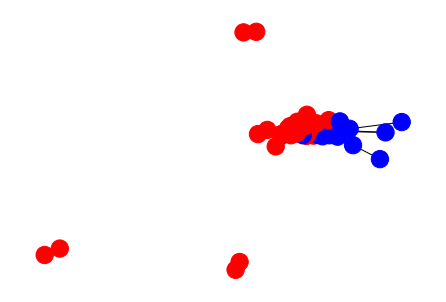

In [53]:
color_map_cluster = np.array([])
for node in G:
    if (predicted_label[node]==0):
        color_map_cluster = np.append(color_map_cluster, 'red')
    elif (predicted_label[node]==1):
        color_map_cluster = np.append(color_map_cluster, 'blue')
    else:
        color_map_cluster = np.append(color_map_cluster, 'yellow')
nx.draw(G, node_color=color_map_cluster)
plt.plot()